In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

In [ ]:
# Import data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["mlproject"]
collection = db["earthquake"]
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))

In [ ]:
#Format data and categorize into groups based on coordinates
df["occurred_on"] = pd.to_datetime(df["occurred_on"], errors="coerce")
df["year"] = df["occurred_on"].dt.year
df.drop(columns=["occurred_on"], inplace=True)

df["depth_category"] = pd.cut(df["depth"], bins=[0, 70, 300, 700], labels=["shallow", "intermediate", "deep"])

def region_bucket(lat, lon):
    if lat > 50 and lon < -150: return "Alaska_Aleutian"
    elif -15 < lat < 10 and 120 < lon < 160: return "Indonesia"
    elif 30 < lat < 45 and 130 < lon < 150: return "Japan"
    elif -25 < lat < -10 and 160 < lon < 180: return "Fiji_Tonga"
    else: return "Other"

df["tectonic_region"] = df.apply(lambda row: region_bucket(row["latitude"], row["longitude"]), axis=1)
df["severity"] = df["magnitude"].apply(lambda x: 3 if x >= 6.0 else 2)



In [ ]:
# We remove 'magnitude' because severity is a direct function of it.
X = df.drop(columns=["earthquake_id", "place", "network_id", "magnitude", "severity"], errors='ignore')
y = df["severity"]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Train the model
model = HistGradientBoostingClassifier(max_depth=10, learning_rate=0.1, max_iter=300, random_state=42)
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=3)
best_threshold = thresholds[np.argmax(tpr - fpr)]


In [ ]:
#Determine metrics
y_pred_optimal = np.where(y_proba > best_threshold, 3, 2)

print(f"Dataset shape: {df.shape}")
print(f"Optimal Decision Threshold: {best_threshold:.4f}")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred_optimal, target_names=["Moderate", "Strong"]))

Dataset shape: (23119, 13)
Optimal Decision Threshold: 0.3275

Accuracy: 0.6821
ROC-AUC: 0.7235
              precision    recall  f1-score   support

    Moderate       0.81      0.71      0.76      3212
      Strong       0.48      0.62      0.54      1412

    accuracy                           0.68      4624
   macro avg       0.65      0.67      0.65      4624
weighted avg       0.71      0.68      0.69      4624



In [ ]:
# Sample prediction
result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
print("\nTop Important Features:\n", pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False).head(5))

sample_proba = model.predict_proba(X_test.iloc[0:1])[:, 1][0]
sample_pred = 3 if sample_proba > best_threshold else 2
print(f"\nSample Prediction - Prob: {sample_proba:.4f} | Result: {'Strong' if sample_pred == 3 else 'Moderate'}")


Top Important Features:
 year                      0.055882
depth                     0.028676
calculation_method_mwb    0.018036
calculation_method_mb     0.016306
longitude                 0.008175
dtype: float64

Sample Prediction - Prob: 0.3487 | Result: Strong


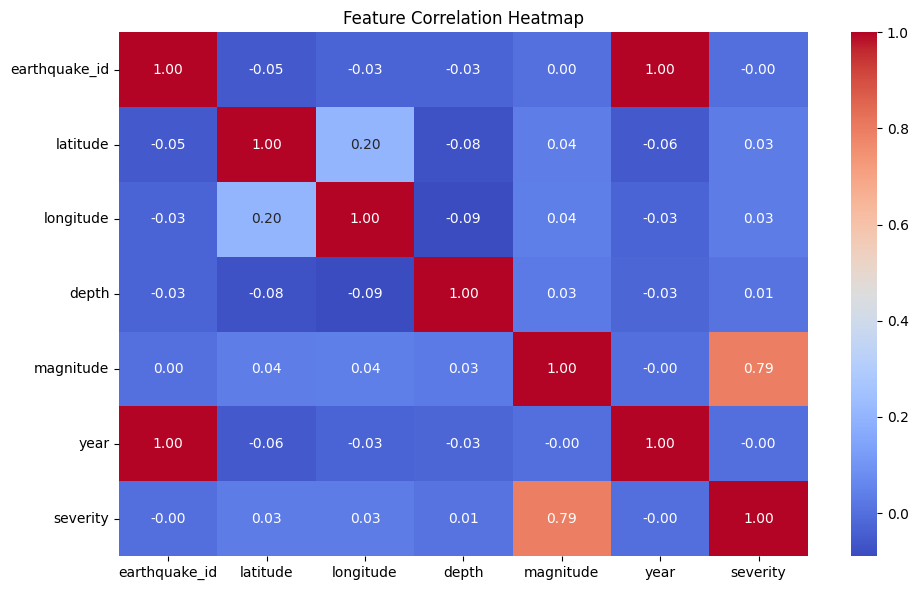

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True),
            annot=True,
            cmap="coolwarm",
            fmt=".2f")

plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

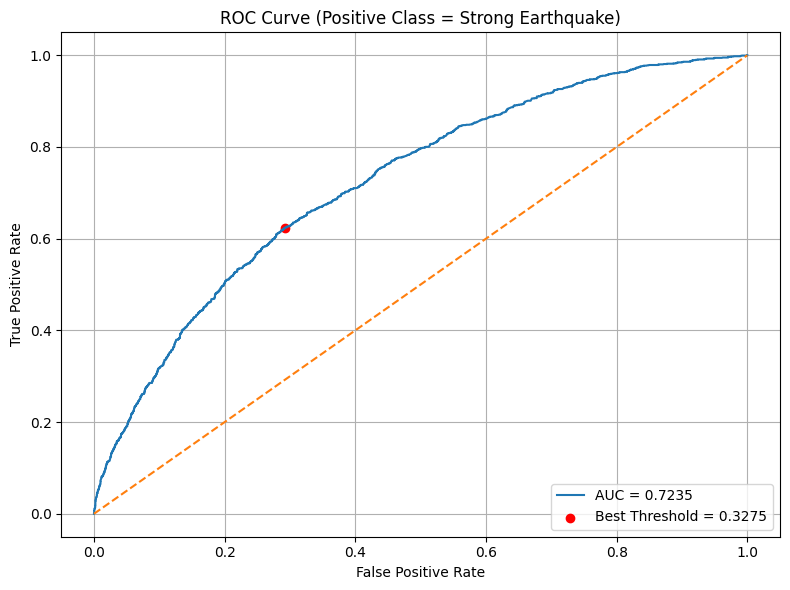

In [ ]:
roc_auc = roc_auc_score(y_test, y_proba)

# Best threshold index
best_idx = np.argmax(tpr - fpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.scatter(fpr[best_idx], tpr[best_idx], color='red',
            label=f"Best Threshold = {thresholds[best_idx]:.4f}")

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Positive Class = Strong Earthquake)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

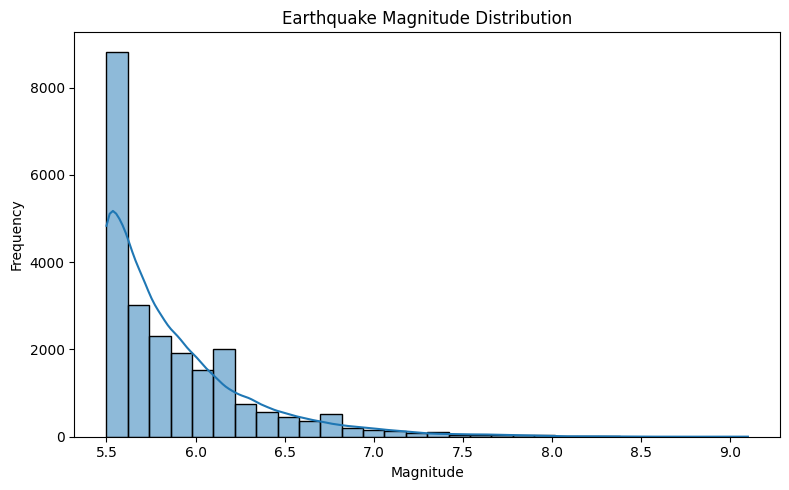

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["magnitude"], bins=30, kde=True)

plt.title("Earthquake Magnitude Distribution")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()